In [1]:
import json
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

import tabulate
import numpy as np
import math

from itertools import cycle, islice

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    #'text.usetex': True,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [3]:
out_dir = join('..', 'plots', 'parallelization')
event_dir = join('..', 'data', 'spark-logs-parallelization')
memory_dir = join(event_dir, 'spark-memory')

In [4]:
appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False

appname = 'BSBM'
data_size_dir = 'BSBM'
collections = ['attribute']#, 'type', 'schemex'] #, 
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
#parallizations = ['parallel_16', 'parallel_8', 'parallel_4', 'parallel_2', 'parallel_1']

suffix = '-test-1'
hide_legend = False
# BSBM_attribute-parallel_1-test-1-performance.csv'

# BSBM-attribute-parallel_1-test-1-performance.csv

# appname = 'DyLDO-core'
# data_size_dir = 'DyLDO-core'
# collections =['attribute', 'type']
# parallizations = ['parallel_1']

# suffix = '-test-2'
#hide_legend = True


#appname = 'dyldo_y2019_full'
#data_size_dir = 'DyLDO-ext'
#collections =['schemex', 'attribute', 'type']
#suffix = ''
#hide_legend = True

appname = 'DyLDO-core'
data_size_dir = 'DyLDO-core'
collections =['attribute']
parallizations = ['parallel_1', 'parallel_2', 'parallel_4', 'parallel_8', 'parallel_16']
suffix = '-test-2'


appname = 'BSBM'
data_size_dir = 'BSBM'
suffix = '-test-1'


hide_legend = False
ticks = 5.0
interpolate = True

In [5]:
FIND_AND_MERGE_STAGE_IDS = [6]

def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   
    captions = ["Iteration",
                "Incremental Start",
                "Incremental End",
                "Incremental Duration",
                "Incremental F&M Duration",
                "Batch Start",
                "Batch End",
                "Batch Duration", 
                "Batch F&M Duration",
                'Memory Min', 
                'Memory Max', 
                'Memory Mean', 'direct-used']

    data_frame = pd.DataFrame(columns=captions)
    data_frame.set_index('Iteration')

    onlyfiles = [f for f in listdir(event_dir) if isfile(join(event_dir, f)) and 'inprogress' not in f]

    for file in onlyfiles:
        with open(join(event_dir, file)) as f:
            
            content = f.readlines()
            batch_computation = False
            iteration_number = -1
            for line in content:
                event = json.loads(line)

                if event['Event'] == 'SparkListenerEnvironmentUpdate':
                    app_name = event['Spark Properties']['spark.app.name']
                    if app_name.startswith(analyze_app):
                        version = app_name.replace(analyze_app, '')
                        if not version:
                            version = '0'
                        if '_batch_' in version:
                            batch_computation = True
                            iteration_number = int(version.replace('_batch_', ''))
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number

                        else:
                            batch_computation = False
                            iteration_number = int(version)
                            if data_frame.loc[data_frame['Iteration'] == iteration_number].empty:
                                data_frame.loc[len(data_frame)] = iteration_number




                if event['Event'] == 'SparkListenerJobStart':
                    start = event['Submission Time']
                    caption = 'Incremental Start'
                    if batch_computation:
                        caption = 'Batch Start'

                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = start

                if event['Event'] == 'SparkListenerJobEnd':
                    end = event['Completion Time']
                    caption = 'Incremental End'
                    if batch_computation:
                        caption = 'Batch End'
                    data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = end
                if event['Event'] == 'SparkListenerStageCompleted':
                    if event['Stage Info']['Stage ID'] in FIND_AND_MERGE_STAGE_IDS:
                        caption = 'Incremental F&M Duration'
                        if batch_computation:
                            caption = 'Batch F&M Duration'
                    
                        start = event['Stage Info']['Submission Time']
                        duration = event['Stage Info']['Completion Time'] - start
                        data_frame.loc[data_frame['Iteration'] == iteration_number, caption] = duration
                
            if isdir(memory_dir):
                """
                 '.driver.jvm.heap.committed.csv',
                 '.driver.jvm.heap.init.csv',
                 '.driver.jvm.heap.max.csv',
                 '.driver.jvm.heap.usage.csv',
                 '.driver.jvm.heap.used.csv',
                 .driver.BlockManager.memory.memUsed_MB.csv
                """
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.used.csv'))
                #mem_df = pd.read_csv(join(memory_dir, file + '.driver.jvm.heap.usage.csv'))
                mem_df = pd.read_csv(join(memory_dir, file + '.driver.BlockManager.memory.memUsed_MB.csv'))
                data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Min'] = mem_df['value'].min()
                data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Max'] = mem_df['value'].max()
                data_frame.loc[data_frame['Iteration'] == iteration_number, 'Memory Mean'] = mem_df['value'].mean()
                mem_df2 = pd.read_csv(join(memory_dir, file + '.driver.jvm.direct.used.csv'))
                data_frame.loc[data_frame['Iteration'] == iteration_number, 'direct-used'] = mem_df2['value'].mean()
                
                
    data_frame['Incremental Duration'] = data_frame['Incremental End'] - data_frame['Incremental Start']
    data_frame['Batch Duration'] = data_frame['Batch End'] - data_frame['Batch Start']

    data_frame = data_frame.sort_values(['Iteration'], ascending=[True])
    data_frame = data_frame.set_index('Iteration')
    return data_frame

In [6]:
iterations = 0


performance_frame = pd.DataFrame() 
run_details_frame = pd.DataFrame()
for collection in collections:
#    new_zero_incr = 0
#    new_zero_batch = 0
    for parallelization in parallizations:
        # def collectStatistics(analyze_app, event_dir='/tmp/spark-events', memory_dir='/tmp/spark-memory'):   

        df = collectStatistics(appname+'-'+collection+'-'+parallelization+suffix, 
                               event_dir=event_dir, 
                               memory_dir=memory_dir) 
        
        performance_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        performance_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        
        run_details_frame[collection+'-'+parallelization+'-Inc'] = df['Incremental Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch'] = df['Batch Duration']
        run_details_frame[collection+'-'+parallelization+'-Inc F&M'] = df['Incremental F&M Duration']
        run_details_frame[collection+'-'+parallelization+'-Batch F&M'] = df['Batch F&M Duration']        
    
    

#performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
#             'AttrColl:Incr', 'AttrColl:Batch',
#             'TypeColl:Incr', 'TypeColl:Batch']
 
convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
run_details_frame = run_details_frame.applymap(convert)

display(performance_frame.head())
display(run_details_frame.head())

if (appname == 'dyldo_y2019_core' or appname == 'DyLDO-core') and len(performance_frame) > 23:
    performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    run_details_frame = run_details_frame.drop(run_details_frame.index[[21,22]])
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    run_details_frame = run_details_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
 

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_16-Inc,attribute-parallel_16-Batch
Iteration,,,,,,,,,,
0,0.300883,0.422300,0.223483,0.244533,0.148633,0.160667,0.155467,0.141883,0.176333,0.162500
1,2.487367,3.174783,1.470883,2.528350,0.993050,1.504200,0.965383,1.133167,1.122800,1.199117
2,4.178717,5.723617,2.610333,5.353800,1.898133,2.661550,1.881367,2.275583,2.055633,2.376483
3,6.352917,8.503567,3.913367,6.188933,2.731000,4.324967,2.903950,3.404133,3.210083,3.378733
4,8.057300,11.315683,4.875683,12.454500,3.621983,5.497783,3.648033,4.306867,4.341450,4.289367


,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_4-Inc F&M,attribute-parallel_4-Batch F&M,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_8-Inc F&M,attribute-parallel_8-Batch F&M,attribute-parallel_16-Inc,attribute-parallel_16-Batch,attribute-parallel_16-Inc F&M,attribute-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,
0,0.300883,0.422300,0.044117,0.178683,0.223483,0.244533,0.035550,0.082483,0.148633,0.160667,0.039217,0.066000,0.155467,0.141883,0.046700,0.053883,0.176333,0.162500,0.061833,0.066250
1,2.487367,3.174783,0.163400,1.123067,1.470883,2.528350,0.210000,1.292550,0.993050,1.504200,0.253900,0.734217,0.965383,1.133167,0.266383,0.421783,1.122800,1.199117,0.428467,0.504467
2,4.178717,5.723617,0.297683,2.127067,2.610333,5.353800,0.326583,3.219317,1.898133,2.661550,0.474500,1.278783,1.881367,2.275583,0.537117,0.991683,2.055633,2.376483,0.727950,1.078600
3,6.352917,8.503567,0.407900,3.175117,3.913367,6.188933,0.542150,2.574317,2.731000,4.324967,0.709150,2.262067,2.903950,3.404133,0.944867,1.472667,3.210083,3.378733,1.256900,1.416900
4,8.057300,11.315683,0.597767,4.109617,4.875683,12.454500,0.630233,7.496367,3.621983,5.497783,0.950817,2.735067,3.648033,4.306867,1.062233,1.740350,4.341450,4.289367,1.795367,1.745217


In [7]:
print(len(performance_frame))
z_lim = performance_frame.max().max()
z_lim += z_lim/10
5 * round(z_lim/5)

41


65

0.20403333333333334
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

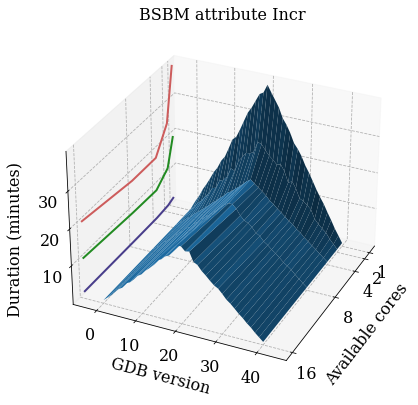

0.32444999999999996
30


[(20, 'indianred'), (30, 'forestgreen'), (40, 'darkslateblue')]

(20, 30, 40)

('indianred', 'forestgreen', 'darkslateblue')

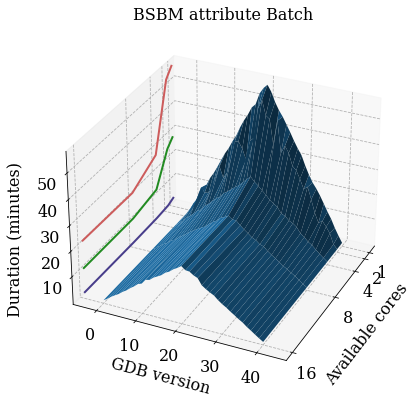

In [24]:
box = dict(facecolor='white', pad=5, alpha=0.2)


def my_3d_plot(x, y, values, plot_name, z_lim=None, save_dir=None):
    y_offset = 5
    
    # prepare data   
    X, Y = np.meshgrid(x, y)
    Z = np.transpose(np.array(values))
    
    
    fig = plt.figure()
    ax = Axes3D(fig)
      
    # plot the data
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # add contour lines for readability
    print(np.min(values[0]))
    min_index = np.argmin(values[0])
    max_index = np.argmax(values[0])
    
    median_index = list(values[0]).index(np.percentile(values[0], 50, interpolation='nearest'))

    print(median_index)
    lvls = [min_index, median_index, max_index]
    colors = ['darkslateblue', 'forestgreen', 'indianred']
    temp = list(zip(lvls, colors))
    temp.sort(key=lambda x: x[0])
    display(temp)
    lvls, colors = zip(*temp)
    display(lvls)
    display(colors)
    
    # TODO: 40 is not displayed properly
    lvls = [20,30,39]
    cset = ax.contour(X, Y, Z, zdir='y', levels=lvls, offset=-y_offset, colors=colors)

    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(plot_name)
    plt.xticks(x)
    ax.view_init(30, 25)
    
    if z_lim:
        ax.set_zlim([0, z_lim])

    ax.set_ylim([-y_offset, len(y)+y_offset])
    
    ax.set_xlabel("Available cores", labelpad=10)
    ax.set_ylabel("GDB version", labelpad=10)

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel("Duration (minutes)", rotation=90, labelpad=10)
    
    #fig.colorbar.remove()
    
    if save_dir:
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.pdf',  bbox_inches='tight')
        plt.savefig(save_dir + '/' + plot_name.replace(' ', '-') + '-parallel.png',  bbox_inches='tight')
        
    plt.show()


for collection in collections:
    values_incr = []
    values_batch = []
    for parallelization in parallizations:
        values_incr.append(np.array(performance_frame[collection+'-'+parallelization+'-Inc']))
        values_batch.append(np.array(performance_frame[collection+'-'+parallelization+'-Batch']))
        
    ## TODO parameterize
    x = [1,2,4,8,16]
    y = np.arange(0, len(performance_frame), 1) # 41

    z_lim = performance_frame.max().max()
    z_lim += z_lim/10
    z_lim = 5 * round(z_lim/5)

    my_3d_plot(x, y, values_incr, '%s %s Incr' % (appname, collection), save_dir=out_dir)
    
    my_3d_plot(x, y, values_batch, '%s %s Batch' % (appname, collection), save_dir=out_dir)


#     for angle in range(0, 360):
#         ax.view_init(30, angle)
#         plt.draw()
#         plt.pause(.001)


In [318]:
def deduplicate(input_list):
    seen = set()
    new_list = []
    for item in input_list:
        if item not in seen:
            new_list.append(item)
            seen.add(item)
    return new_list


In [255]:
# some speed-up analysis
#display(performance_frame)
speed_up_frame = pd.DataFrame(columns=deduplicate([x.replace('-Inc', '').replace('-Batch', '') for x in performance_frame.columns]))

for collection in collections:
    for parallelization in parallizations:
        speed_up_frame[collection+'-'+parallelization] = performance_frame[collection+'-'+parallelization+'-Batch'] /performance_frame[collection+'-'+parallelization+'-Inc']
        print('batch runs faster than incremental for %s: %s' % (collection+'-'+parallelization, (speed_up_frame[collection+'-'+parallelization] < 1.0).sum()))

display(speed_up_frame.mean())
display(speed_up_frame.std())    
display(speed_up_frame.mean().min())
display(speed_up_frame.mean().max())  

batch runs faster than incremental for attribute-parallel_1: 0
batch runs faster than incremental for attribute-parallel_2: 0
batch runs faster than incremental for attribute-parallel_4: 0
batch runs faster than incremental for attribute-parallel_8: 1
batch runs faster than incremental for attribute-parallel_16: 3


attribute-parallel_1     1.440052
attribute-parallel_2     1.826764
attribute-parallel_4     1.464468
attribute-parallel_8     1.162826
attribute-parallel_16    1.068840
dtype: float64

attribute-parallel_1     0.050394
attribute-parallel_2     0.304808
attribute-parallel_4     0.081707
attribute-parallel_8     0.049375
attribute-parallel_16    0.042953
dtype: float64

1.068839901323514

1.8267636241144853

In [256]:
t1 = (performance_frame['attribute-parallel_1-Batch'] /performance_frame['attribute-parallel_1-Inc']).mean()
t2 = (performance_frame['attribute-parallel_1-Batch'].sum() /performance_frame['attribute-parallel_1-Inc'].sum())

In [257]:
display(t1)
display(t2)

1.440051708050351

1.4408311354606362

In [258]:


for collection in collections:
    for parallelization in parallizations:
        macro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)] /performance_frame['%s-%s-Inc'  % (collection, parallelization)]).mean()
        micro_avg = (performance_frame['%s-%s-Batch' % (collection, parallelization)].sum() /performance_frame['%s-%s-Inc'  % (collection, parallelization)].sum())
        print('%s - Micro Avg: %s' % (parallelization, micro_avg.round(2)))
        print('%s - Macro Avg: %s' % (parallelization, macro_avg.round(2)))

parallel_1 - Micro Avg: 1.44
parallel_1 - Macro Avg: 1.44
parallel_2 - Micro Avg: 1.86
parallel_2 - Macro Avg: 1.83
parallel_4 - Micro Avg: 1.48
parallel_4 - Macro Avg: 1.46
parallel_8 - Micro Avg: 1.17
parallel_8 - Macro Avg: 1.16
parallel_16 - Micro Avg: 1.07
parallel_16 - Macro Avg: 1.07


In [225]:
print((all_frame['batch'] / all_frame['incr']).mean())
print(all_frame['batch'].sum() / all_frame['incr'].sum())

7.6354887707748675
7.960062110656028


In [166]:
for col in performance_frame.columns:
    if 'parallel_1-Inc' in col:
        #baseline
        baseline = performance_frame[col]
    elif '-Batch' in col:
        print('%s has faster runs than baseline? %s' % (col, (performance_frame[col] - baseline < 0).sum()))
        

attribute-parallel_1-Batch has faster runs than baseline? 0
attribute-parallel_2-Batch has faster runs than baseline? 9
attribute-parallel_4-Batch has faster runs than baseline? 41
attribute-parallel_8-Batch has faster runs than baseline? 41
attribute-parallel_16-Batch has faster runs than baseline? 41


In [167]:
parallelization_frame = pd.DataFrame()
for collection in collections:
    for i in range(1, len(parallizations)):
        prev = parallizations[i-1]
        current = parallizations[i]
        parallelization_frame[collection+'-'+current+'-Batch'] = performance_frame[collection+'-'+prev+'-Batch'] / performance_frame[collection+'-'+current+'-Batch'] 
        parallelization_frame[collection+'-'+current+'-Inc'] = performance_frame[collection+'-'+prev+'-Inc'] / performance_frame[collection+'-'+current+'-Inc'] 
            
display(parallelization_frame.mean())
display(parallelization_frame.std())

attribute-parallel_2-Batch     1.251550
attribute-parallel_2-Inc       1.549479
attribute-parallel_4-Batch     1.748837
attribute-parallel_4-Inc       1.404745
attribute-parallel_8-Batch     1.240013
attribute-parallel_8-Inc       0.984821
attribute-parallel_16-Batch    0.984149
attribute-parallel_16-Inc      0.904780
dtype: float64

attribute-parallel_2-Batch     0.203753
attribute-parallel_2-Inc       0.091678
attribute-parallel_4-Batch     0.264972
attribute-parallel_4-Inc       0.060656
attribute-parallel_8-Batch     0.049788
attribute-parallel_8-Inc       0.023703
attribute-parallel_16-Batch    0.030420
attribute-parallel_16-Inc      0.029302
dtype: float64

In [168]:
# overall gain:
skip_rows = 1

t_frame = performance_frame[collection+'-parallel_1-Batch'] / performance_frame[collection+'-parallel_16-Batch']
print('Speed-up batch 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc'] / performance_frame.iloc[skip_rows:][collection+'-parallel_16-Inc']
print('Speed-up incr. 1 to 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))


Speed-up batch 1 to 16 between 2.4084 and 2.7197 (mean: 2.6055 +- 0.0718)
Speed-up incr. 1 to 16 between 1.8324 and 2.2153 (mean: 1.9399 +- 0.0679)


In [158]:
# one core incr. vs 16 core batch

t_frame = performance_frame.iloc[skip_rows:][collection+'-parallel_16-Batch'] / performance_frame.iloc[skip_rows:][collection+'-parallel_1-Inc']
print('Speed-up incr. 1 to batch 16 between %.4f and %.4f (mean: %.4f +- %.4f)' % (t_frame.min(), t_frame.max(), t_frame.mean(), t_frame.std()))



Speed-up incr. 1 to batch 16 between 1.1549 and 2.3571 (mean: 1.7871 +- 0.2676)


In [153]:
display(performance_frame.iloc[skip_rows:].mean())
display(performance_frame.iloc[skip_rows:].std())
display(performance_frame.iloc[skip_rows:].min())
display(performance_frame.iloc[skip_rows:].max())

attribute-parallel_1-Inc        25.034720
attribute-parallel_1-Batch     236.289836
attribute-parallel_2-Inc        17.663532
attribute-parallel_2-Batch     238.580033
attribute-parallel_4-Inc        11.834798
attribute-parallel_4-Batch      91.185660
attribute-parallel_8-Inc        11.764677
attribute-parallel_8-Batch      47.586828
attribute-parallel_16-Inc       11.856603
attribute-parallel_16-Batch     43.425791
dtype: float64

attribute-parallel_1-Inc        5.602179
attribute-parallel_1-Batch     60.318306
attribute-parallel_2-Inc        4.815577
attribute-parallel_2-Batch     67.011088
attribute-parallel_4-Inc        2.537381
attribute-parallel_4-Batch     22.230847
attribute-parallel_8-Inc        2.492596
attribute-parallel_8-Batch      9.716144
attribute-parallel_16-Inc       2.537572
attribute-parallel_16-Batch     3.626592
dtype: float64

attribute-parallel_1-Inc        18.507467
attribute-parallel_1-Batch     157.426717
attribute-parallel_2-Inc        12.587800
attribute-parallel_2-Batch     108.926283
attribute-parallel_4-Inc         8.780233
attribute-parallel_4-Batch      62.706933
attribute-parallel_8-Inc         8.787433
attribute-parallel_8-Batch      35.777183
attribute-parallel_16-Inc        8.809167
attribute-parallel_16-Batch     37.368867
dtype: float64

attribute-parallel_1-Inc        43.385167
attribute-parallel_1-Batch     337.940333
attribute-parallel_2-Inc        34.325000
attribute-parallel_2-Batch     347.388217
attribute-parallel_4-Inc        19.916200
attribute-parallel_4-Batch     126.312883
attribute-parallel_8-Inc        19.368483
attribute-parallel_8-Batch      65.100417
attribute-parallel_16-Inc       20.218383
attribute-parallel_16-Batch     51.199283
dtype: float64

In [240]:
mux = pd.MultiIndex.from_product([['1','2','4', '8', '16'], ['incr.','batch']])
df = pd.DataFrame(columns=mux)
df

Empty DataFrame
Columns: [(1, incr.), (1, batch), (2, incr.), (2, batch), (4, incr.), (4, batch), (8, incr.), (8, batch), (16, incr.), (16, batch)]
Index: []

In [243]:
latex_frame = performance_frame.copy()
latex_frame.columns = ['1 core incr.', '1 core batch',
                       '2 core incr.', '2 core batch',
                       '4 core incr.', '4 core batch',
                       '8 core incr.', '8 core batch',
                       '16 core incr.', '16 core batch']
latex_frame.columns = mux
latex_frame.index.rename('GDB Version', True)
latex_frame = latex_frame.round(2)
display(latex_frame.mean())

1   incr.     26.418571
    batch    237.261429
2   incr.     19.244694
    batch    239.488980
4   incr.     12.406327
    batch     91.508571
8   incr.     12.282041
    batch     47.726531
16  incr.     12.497551
    batch     43.492653
dtype: float64

In [242]:
print(latex_frame.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{1} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{4} & \multicolumn{2}{l}{8} & \multicolumn{2}{l}{16} \\
{} &  incr. &   batch &  incr. &   batch &  incr. &   batch &  incr. &  batch &  incr. &  batch \\
GDB Version &        &         &        &         &        &         &        &        &        &        \\
\midrule
0           &  92.86 &  283.90 &  95.11 &  283.09 &  39.83 &  106.99 &  37.10 &  54.42 &  43.25 &  46.69 \\
1           &  25.81 &  305.87 &  17.38 &  292.06 &  12.17 &  107.85 &  12.28 &  55.48 &  12.19 &  43.91 \\
2           &  31.76 &  275.94 &  22.01 &  296.63 &  15.49 &  112.29 &  15.66 &  58.45 &  15.23 &  47.56 \\
3           &  30.77 &  271.41 &  20.65 &  279.24 &  14.72 &  109.03 &  16.40 &  55.53 &  14.52 &  47.94 \\
4           &  27.85 &  277.38 &  18.53 &  239.95 &  13.06 &  106.22 &  13.59 &  53.38 &  12.99 &  43.01 \\
5           &  29.48 &  299.97 &  22.17 &  325.51 &  14.49 &  113.76 &  14.56 &

# run details


In [181]:
display(run_details_frame.head())

,attribute-parallel_1-Inc,attribute-parallel_1-Batch,attribute-parallel_1-Inc F&M,attribute-parallel_1-Batch F&M,attribute-parallel_2-Inc,attribute-parallel_2-Batch,attribute-parallel_2-Inc F&M,attribute-parallel_2-Batch F&M,attribute-parallel_4-Inc,attribute-parallel_4-Batch,attribute-parallel_4-Inc F&M,attribute-parallel_4-Batch F&M,attribute-parallel_8-Inc,attribute-parallel_8-Batch,attribute-parallel_8-Inc F&M,attribute-parallel_8-Batch F&M,attribute-parallel_16-Inc,attribute-parallel_16-Batch,attribute-parallel_16-Inc F&M,attribute-parallel_16-Batch F&M
Iteration,,,,,,,,,,,,,,,,,,,,
0,92.857167,283.901700,69.597667,260.103333,95.112483,283.088183,79.320550,266.743000,39.834633,106.987850,31.147267,97.753300,37.096467,54.417700,28.700983,45.030550,43.252483,46.691500,34.776600,38.029017
1,25.812483,305.867783,2.958717,282.671833,17.379867,292.061767,3.319133,277.901133,12.174217,107.851033,3.428767,99.117733,12.276383,55.475617,3.405000,46.179250,12.194617,43.912917,4.007367,35.748817
2,31.759583,275.939233,4.654867,248.296017,22.008100,296.629633,5.182967,278.070567,15.491433,112.289467,4.809100,101.506867,15.663150,58.446567,4.763950,47.100333,15.232383,47.556050,5.450700,37.784867
3,30.771333,271.406067,3.472917,244.266283,20.651500,279.241017,4.353433,262.364583,14.719383,109.025450,4.246133,98.457850,16.397883,55.528250,4.147183,44.959833,14.518000,47.938517,4.946300,38.174350
4,27.845867,277.382283,3.457350,253.676700,18.527233,239.947183,4.116433,225.516167,13.056583,106.222317,3.968483,97.044733,13.591733,53.378167,3.809600,43.738450,12.988733,43.012300,4.565700,34.464167


In [182]:
find_and_merge_frame = pd.DataFrame()
for collection in collections:
    for i in range(0, len(parallizations)):
        current = parallizations[i]
        find_and_merge_frame[collection+'-'+current+'-Batch'] = run_details_frame[collection+'-'+current +'-Batch F&M'] / run_details_frame[collection+'-'+current+'-Batch'] 
        find_and_merge_frame[collection+'-'+current+'-Inc'] = run_details_frame[collection+'-'+current+'-Inc F&M'] / run_details_frame[collection+'-'+current+'-Inc'] 
            
display(find_and_merge_frame.mean())
display(find_and_merge_frame.std())

attribute-parallel_1-Batch     0.909583
attribute-parallel_1-Inc       0.167052
attribute-parallel_2-Batch     0.943794
attribute-parallel_2-Inc       0.260654
attribute-parallel_4-Batch     0.910360
attribute-parallel_4-Inc       0.326474
attribute-parallel_8-Batch     0.827826
attribute-parallel_8-Inc       0.314405
attribute-parallel_16-Batch    0.828406
attribute-parallel_16-Inc      0.377422
dtype: float64

attribute-parallel_1-Batch     0.011183
attribute-parallel_1-Inc       0.115721
attribute-parallel_2-Batch     0.011034
attribute-parallel_2-Inc       0.128815
attribute-parallel_4-Batch     0.009719
attribute-parallel_4-Inc       0.087064
attribute-parallel_8-Batch     0.013499
attribute-parallel_8-Inc       0.081093
attribute-parallel_16-Batch    0.021914
attribute-parallel_16-Inc      0.082160
dtype: float64

# other stuff

In [111]:
import numpy as np
import matplotlib.pyplot as plt




In [161]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')
display(size_frame.head())


,|V|,schemex:|V_vs|,schemex:|E_vs|,attribute:|V_vs|,attribute:|E_vs|,type:|V_vs|,type:|E_vs|,0
Iteration,,,,,,,,
0,7271943,243423,1303004,50208.0,706205.0,42300.0,0.0,82221979
1,7509702,249691,1413856,54281.0,781832.0,39785.0,0.0,82245640
2,7064987,240266,1333850,52570.0,744073.0,39088.0,0.0,82381421
3,10592783,232566,1405716,56388.0,790516.0,31781.0,0.0,106491385
4,10440827,225972,1370282,55389.0,785474.0,31194.0,0.0,105755426


In [162]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

6382958

10718848

9097698.909090908

1663543.6874221521

drop the beat


,|V|,SchemEX:|V_vs|,SchemEX:|E_vs|,AttrColl:|V_vs|,AttrColl:|E_vs|,TypeColl:|V_vs|,TypeColl:|E_vs|,|E|
Iteration,,,,,,,,
0,7271943,243423,1303004,50208.0,706205.0,42300.0,0.0,82221979
1,7509702,249691,1413856,54281.0,781832.0,39785.0,0.0,82245640
2,7064987,240266,1333850,52570.0,744073.0,39088.0,0.0,82381421
3,10592783,232566,1405716,56388.0,790516.0,31781.0,0.0,106491385
4,10440827,225972,1370282,55389.0,785474.0,31194.0,0.0,105755426


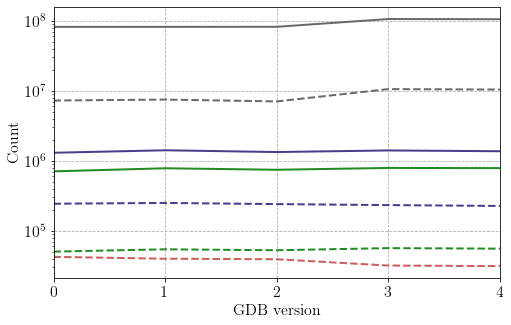

In [163]:
size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
   

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
  
display(size_frame)

sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                       color=['darkslateblue', 'darkslateblue',
                             'forestgreen','forestgreen',
                             'indianred','indianred', 'dimgray', 'dimgray'])#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
#ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
#plt.yticks(np.arange(0, iterations, 5.0))
#plt.
plt.xticks(np.arange(0, iterations, ticks))
ax.set_xlabel("GDB version")
ax.set_ylabel("Count")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)
if hide_legend:
    ax.get_legend().remove()
    
plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')

Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')
Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')
Index(['NewlyObservedSchema (SE_new)', 'DeletedSchemaStructures (SE_del)',
       'ChangedSchemaStructures (SE_mod)', 'InstanceNotChanged (PE_mod)'],
      dtype='object')


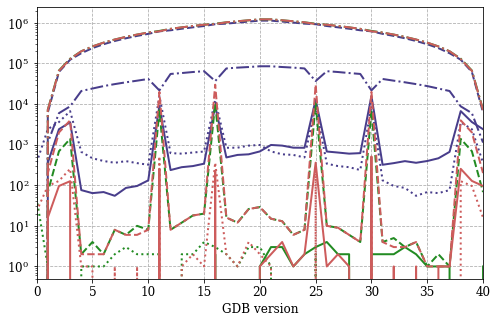

In [9]:
frames = [None, None, None]
i = 0
iterations = 0
for collection in collections:
    with open(os.path.join(data_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()

        #del df['NewlyObservedSchema (SE_new)']
        #del df['DeletedSchemaStructures (SE_del)']

        
        del df['TotalNumberOfNewInstances'] 
        del df['InstanceAddedWithKnownSchema (PE_add)']
        del df['InstancesDeleted (PE_del)']
        del df['ChangedSchemaStructuresBecauseOfNeighbor'] 
        del df['PayloadEntriesAdded'] 
        del df['PayloadEntriesRemoved'] 
        del df['InstanceToSchemaLinksAdded'] 
        del df['InstanceToSchemaLinksRemoved'] 

        del df['TotalNumberOfChangedPayloadElements (real PE_mod)']
        
        del df['TotalNumberOfSchemaElementsWritten']
        del df['TotalNumberOfSchemaElementsDeleted']
        #del df['InstanceNotChanged (PE_mod)']
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')
        print(df.columns)
        df.columns = [collection+'ADD', collection+'DEL', collection+'MOD', collection+'unchanged']    #'Modified pe(v)'
        
        #df.columns = [collection+'MOD-ELEM', collection+'Unchanged v', collection+'ADD-ELEM', collection+'DEL-ELEM']    #'Modified pe(v)'
        #df = df[[collection+'ADD-ELEM', collection+'DEL-ELEM', collection+'MOD-ELEM',collection+'Unchanged v']] #'Modified pe(v)'
        frames[i] = df
        i = i + 1
        
df = pd.concat(frames, sort=False)


df.columns = ['SchemEX:ADD', 'SchemEX:DEL', 'SchemEX:MOD','SchemEX:PAY',
             'AttrColl:ADD', 'AttrColl:DEL', 'AttrColl:MOD','AttrColl:PAY',
             'TypeColl:ADD', 'TypeColl:DEL', 'TypeColl:MOD','TypeColl:PAY']
ax = df.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'], 
             color=['darkslateblue', 'darkslateblue', 'darkslateblue', 'darkslateblue', 
                    'forestgreen', 'forestgreen', 'forestgreen','forestgreen',
                   'indianred', 'indianred', 'indianred','indianred'])
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
plt.xticks(np.arange(0, iterations, 5.0))
ax.set_xlabel("GDB version")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.325), shadow=True, ncol=3)

if hide_legend:
    ax.get_legend().remove()

plt.grid(True)
plt.savefig(out_dir + '/' + appname + '-changes.png', bbox_inches = 'tight')